## 简介：手动特征工程 part 1

如果你是初次参与这个竞赛，我强烈建议你先阅读这个文档https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/

在这份文档中，我们首先会研究如何通过手工的方式，处理捷信公司贷款违约风险问题的相关特征。在更早之前的一篇文章中，我们仅仅使用了贷款申请数据来建模。我们利用该数据所建立的最佳模型在排行榜上的分数大约是0.74。为了提高这个分数，我们需要从其他数据中引入更多的信息，包括bureau和bureau_balance数据。数据的定义如下：
bureau:捷信公司(Home Credit，下同)所掌握的客户从其他金融机构中贷款的历史信息。其中每一行代表一条历史贷款信息
bureau_balance:历史贷款的月度信息。其中每一行代表一条月度信息

手动特征工程是一个很无聊的过程（这就是我们为什么需要使用自动化的特征处理工具来处理我们的数据），而且该过程经常需要依靠该领域的专家知识来辅助处理。由于我对贷款行业和客户违约原因知之甚少，所以我的关注点集中在如何收集尽量多的数据来训练模型，原因在于模型会代替我们来评估哪些数据比较重要。简而言之，我们的方法就是获得尽量多的数据提供给模型使用！接着我们可以利用特征的重要性或是PCA降维等方法来进行特征约减

进行手动特征工程的过程需要大量Pandas代码，一点点耐心和许多操作数据的实践。尽管自动化的特性工程工具已经十分遍历，但是特性工程仍然需要使用大量数据清洗重组(data wrangle)一段时间才能完成

In [4]:
#使用 pandas 和 numpy 进行数据处理
import pandas as pd
import numpy as np

#使用 matplotlib 和 seaborn 进行绘制
import matplotlib.pyplot as plt
import seaborn as sns

#禁止 pandas 的编译警告
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## 案例：计算客户历史贷款总数

为了解释常见的手工特征工程流程，我们首先计算一个客户在其他金融机构的历史贷款信息总和，这一过程会用到许多我们接下去会频繁使用到的Pandas操作：

* groupby: 按列对数据进行分组。在这个案例中我们根据具有唯一性的SK_ID_CURR列进行分组【按列进行分组？不是按行吗？】
* agg: 对分组后的数据进行计算，例如列均值。我们可以直接使用方程(grouped_df.mean())或者将agg方程与转换后的列表一起使用(grouped_df.agg([mean, max, min, sum]))
* merge: 将聚合后的数据与对应的客户匹配。我们需要将原始训练数据与计算后的SK_ID_CURR列数据结合在一起，如果SK_ID_CURR列没有对应的用户数据，则置为NaN。

我们还经常使用（重命名）函数来将指定的列(columns)重命名为字典(dictionary)，这有利于对新创建的特征保持观察

这看起来有点复杂，所以最终需要构造一个函数来代替我们执行这个过程。但首先，我们需要了解如何手工实现这个过程

In [5]:
# 读入bureau属性
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
# 按照客户id (SK_ID_CURR) 进行Groupeby操作，计算历史贷款总数，并将SK_ID_BUREAU列重命名为previous_loan_counts
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [7]:
# 将计算得到的previous_loan_counts列加入原先的训练数据application_train.csv
train = pd.read_csv('application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')# 左连接，左侧DataFrame取全部，右侧DataFrame取部分

# 填补缺失值
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


向左滑动查看新插入的列

## 使用r值检验方法评估新属性（变量）
为了确定新加入的变量是否有用，我们计算了该变量与目标值之间的皮尔森相关系数(Pearson Correlation Coeffcient, r-value)。该系数可以评估两个变量之间的线性关系强弱，范围在[-1, 1]之间。r值检验方法并不是检验新变量“有效性”最好的方法，但是它可以给出一个新变量对于机器学习模型是否有帮助的初步估计。新变量r值检验的值越大，那么该变量的改变对于目标值的影响就越大。因此,我们希望寻找到与目标值的之间，皮尔森相关系数绝对值最大的新变量

### 核密度估计图
核密度估计图展示的是一个单独变量的分布（可以将其看做一个平滑的直方图），为了看到某个分类中变量的值对分布函数的影响，我们根据类别对不同的分布使用不同的颜色标注。例如，我们可以通过目标值为1或0来判断previous_loan_count变量的核密度估计，所得到的KDE可以显示出未偿还贷款的人(TARGET==1)和偿还贷款的人(TARGET==0)之间变量分布的所有显著性差异，这将作为变量是否与机器学习模型相关的指标

我们将把这个绘图功能放在一个函数中，以便对任何变量重复使用

In [8]:
# 绘制根据不同目标值着色的变量分布
def kde_target(var_name, df):
    
    # 计算变量与目标值之间的皮尔森相关系数
    corr = df['TARGET'].corr(df[var_name])
    
    # 计算偿还或未偿还贷款数据的中位数
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()# df.ix：索引函数，既可以通过行号索引，也可以通过行标签索引
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # 绘制偿还或未偿还贷款数据的分布
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # 标签绘制
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();# 显示图例
    
    # 输出皮尔森相关系数
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # 输出均值
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

我们可以利用EXT_SOURCE_3变量来测试该方程，这是根据随机森林和梯度提升机得出的最佳变量https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


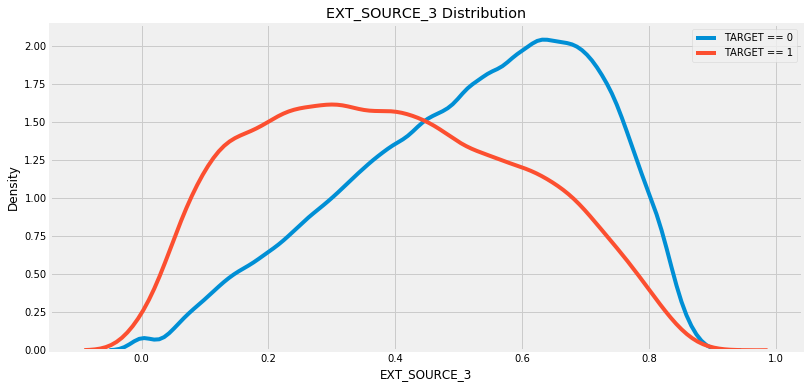

In [9]:
kde_target('EXT_SOURCE_3', train)

接下来对新变量previous_loan_counts进行同样的操作

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


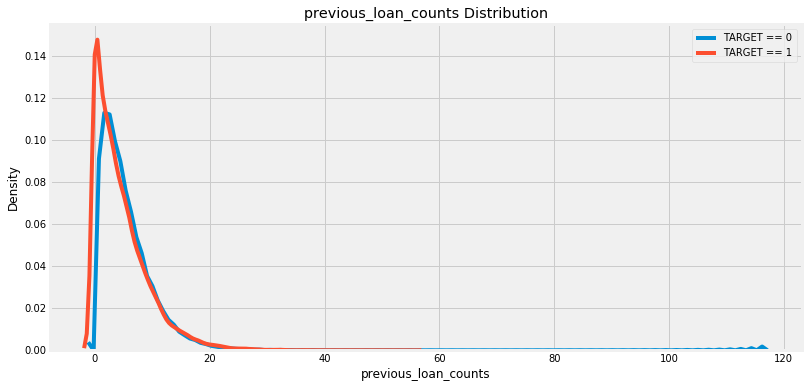

In [10]:
kde_target('previous_loan_counts', train)

从图上看，很难说这个变量是否重要。相关系数很弱并且分布几乎没有什么显著差异

让我们继续从bureau数据中尝试生成更多变量，我们考虑每个数值列的均值，最小值和最大值 

## 聚合数值列
为了考虑bureau数据集中的数值信息，我们对所有数值列做一些计算处理。
为此，我们将数据按照用户id分组(groupby)，分组后的数据再进行聚合(agg)操作，最后将结果合并(merge)到训练数据集中。由于聚合(agg)操作只能在数值型数据中使用，所有我们只计算数值列的值。在这里我们依然使用均值(mean)、最大值(max)、最小值(min)和总和(sum)函数，但事实上任何函数都可以在agg函数中被调用，甚至包括自己编写的函数

In [11]:
# 按照用户id分组并聚合数据
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                 ...    DAYS_CREDIT_UPDATE                               \
  mean max min   ...                 count        mean  max   min   sum   
0  0.0   0   0   ...                     7  -93.142857   -6  -155  -652   
1  0.0   0   0   ...                     8 -499.875000   -7 -1185 -3999   
2  0.0   0   0   ...                     4 -816.000000  -43 -2131 -3264   
3  0.0   0   0   ...                     2 -532.000000 -382  -682 -1064   
4  0.0   0   0   ...                     3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

我们需要为每一列创建新的名称。下面的代码通过结合bureau字段生成新名称。但是利用上述方法生成数据文件具有多级索引，我发现这会让这些数据变得难以理解和处理，所以我想尽快将其削减为单级结构

In [12]:
# 列表的列名称
columns = ['SK_ID_CURR']

# 根据变量名迭代
for var in bureau_agg.columns.levels[0]:
    # 跳过id名（因为id名的mean、max...统计量没有任何意义）
    if var != 'SK_ID_CURR':
    
        #通过结合bureau字段生成新名称
        for stat in bureau_agg.columns.levels[1][:-1]:# 遍历第二行的所有列
            columns.append('bureau_%s_%s' % (var, stat))

In [13]:
# 将生成的类名列表作为新的类名
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


现在我们只需要简单地将之前处理好的数据与训练数据结合在一起

In [14]:
# 与训练数据结合
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### 聚合值和目标的相关性
我们可以计算新的变量与目标值之间的相关性，同样的，我们可以用该相关系数作为变量对于模型重要性的一个估计

In [15]:
# 相关系数列表
new_corrs = []

# 根据变量名迭代
for col in columns:
    # 计算与目标值之间的相关系数
    corr = train['TARGET'].corr(train[col])
    
    
    # 以tuple的形式存入list中
    
    
    new_corrs.append((col, corr))

在下面的代码中，我们使用Python中的排序函数来对相关系数按照绝对值的大小进行排序。同时，我们还使用了Python中的另一个重要操作——匿名函数lambda

In [16]:
# 对相关系数按照绝对值的大小进行排序
# 使用反转操作，确保最大值在list的最前面
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15] # 输出前15个数据

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

没有一个新变量与目标值TARGET有显著的相关性。我们可以从KDE图中看出，最高相关性的向量——bureau_DAYS_CREDIT_mean与目标值TARGET在绝对值方面的相关性

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


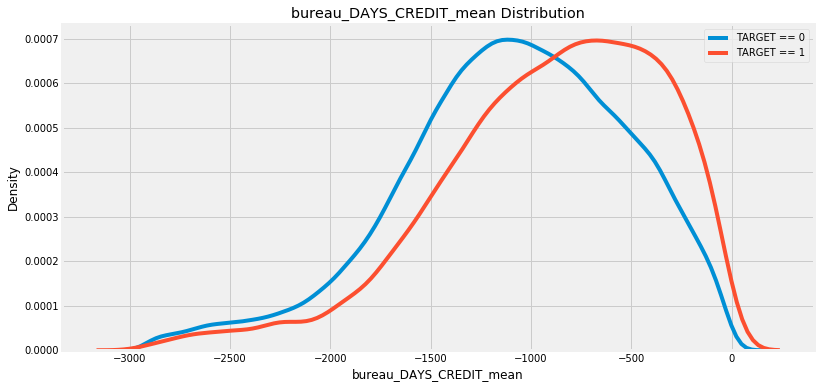

In [17]:
kde_target('bureau_DAYS_CREDIT_mean', train)

这一列的定义是：客户前一次申请贷款距离现在的天数。我的解释是：这是在此次申请捷信公司贷款之前，距离上一次向其他金融机构申请贷款中间所隔的天数。因此，负数的绝对值越大，意味着前一次的贷款越久远(-835.333/-1067)。我们看到，这个变量的平均值与目标之间存在着极弱的正相关关系，这意味着更早之前申请贷款的客户更有可能向Home Credit偿还贷款（不违约），尽管这种微弱的相关性很可能是噪声

### 多重比较问题
让我们将之前的工作封装成一个函数，这样就可以在任何数值型数据中使用该方法。当我们想要对其他数据进行同样的操作时，只需要重用该函数

In [18]:
def agg_numeric(df, group_var, df_name):
    """聚合数值型数据，可以用于为每个分组变量的实例创建新特征
    
    参数
    --------
        df (dataframe): 
            数据文件
        group_var (string): 
            用于将数据文件分组的变量
        df_name (string): 
            用于重命名列名的变量
            
    返回值
    --------
        agg (dataframe): 
            包含所有数值列聚合后统计量的数据文件，分组变量的每个实例都将计算出相应的统计量（平均值、最小值、最大值和总和）
            为了便于追踪所创建这些新变量，这些数值列同时会被重命名  
    """
    # 除去分组变量以外的id变量
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number') # 选择数值列【df只剩下id列和需要分组的列？】
    numeric_df[group_var] = group_ids
    
    # 通过指定变量分组并计算统计数据
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # 需要新建一个列名
    columns = [group_var]
    
    # 根据变量名迭代
    for var in agg.columns.levels[0]:
        # 跳过分组变量
        if var != group_var:
            #通过结合相关字段生成新名称
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    return agg

In [19]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


为了保证该函数按照预期的效果执行，我们需要与手工创建的聚合数据做对比

In [20]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


观察这些值可以发现它们是等价的，所以我们可以在其他数据集上重用该函数。通过使用函数减少工作量，是我们未来需要不断努力的方向

### 相关系数函数
在继续下一步之前，我们同样可以封装计算变量与目标值之间相关系数的函数

In [21]:
# 计算数据集中变量与目标值之间相关系数的函数
def target_corrs(df):
    
    # 相关系数数组
    corrs = []
    
    # 按列迭代
    for col in df.columns:
        print(col)
        # 跳过目标列
        if col != 'TARGET':
            # 计算相关系数
            corr = df['TARGET'].corr(df[col])
            
            # 按tuple类型插入数组中
            corrs.append((col, corr))
    
    # 按照相关系数绝对值大小排序
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

## 类别变量(Categorical Variables)
现在我们从数值列转向分类列。这些是离散型的字符串变量，所以我们无法计算均值或者最大值之类的统计量。相反，我们需要计算每个类别变量中类别的数量。举个例子，如果我们有以下的数据：
SK_ID_CURR	Loan type
1	home
1	home
1	home
1	credit
2	credit
3	credit
3	cash
3	cash
4	credit
4	home
4	home
我们将使用这些信息，计算每个客户在每个类别的贷款数量
SK_ID_CURR	credit count	cash count	home count	total count
1	1	0	3	4
2	1	0	0	1
3	1	2	0	3
4	1	0	2	3
然后，我们可以通过该分类变量出现的总数来标准化这些数据（这意味着每行规范化后的数据总和必须为1.0）
SK_ID_CURR	credit count	cash count	home count	total count	credit count norm	cash count norm	home count norm
1	1	0	3	4	0.25	0	0.75
2	1	0	0	1	1.00	0	0
3	1	2	0	3	0.33	0.66	0
4	1	0	2	3	0.33	0	0.66
希望用这种方式对类别变量进行编码可以获得它们所包含的信息。如果你们对这个过程有更好的想法，请在评论中告诉我！我们一步步进行这个过程，最后我将把所有的代码打包成一个函数，用于不同数据集的重用

首先我们对分类列（dType＝=“object）的数据文件进行oen-hot编码

In [22]:
# 使用get_dummies进行one-hot编码，该方法会为列中的每个字符串创建一个新列
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [23]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      ...  CREDIT_TYPE_Microloan       \
                                  sum mean ...                    sum mean   
SK_ID_CURR                                 ...                               
100001                              7  1.0 ...                      0  0.0   
100002                              8  1.0 ...                      0  0.0   
100003                              4  1.0 ...                      0  0.0   
100004                              2  1.0 ...                      0  0.0   
100005                              3  1.0 ...                      0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

'sum'列表示的是与该类别相关联的客户总数，'mean'列表示的是其归一化计数。one-hot编码函数使得这些数值的计算变得十分容易

我们可以像之前一样对列名进行重命名，同样的，我们需要处理列的多层索引问题。我们将第一级（0层）的分类变量名与one-hot编码后的值结合，迭代进行该过程。例如：sum列将会变成 CREDIT_ACTIVE_Active_count

In [24]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [25]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [26]:
group_var = 'SK_ID_CURR'

# 新建的列名
columns = []

# 迭代变量名
for var in categorical_grouped.columns.levels[0]:
    # 忽略分组变量
    if var != group_var:
        # 迭代统计量名称sum、mean
        for stat in ['count', 'count_norm']:
            columns.append('%s_%s' % (var, stat))

# 重命名列
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


'sum'列记录了客户总数，'mean'列记录了归一化后的值

我们可以将该数据合并到训练数据中

In [27]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index  =True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
train.shape

(307511, 229)

In [29]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


类别变量处理函数
为了使代码更加高效，我们同样对上述方法进行封装，用于处理数据中的类别变量。与agg_numeric函数相同，该函数接受一个数据文件(dataframe)和分组变量(grouping variable)，然后计算数据文件中所有类别变量每个类别的总数和归一化后的数值

In [30]:
def count_categorical(df, group_var, df_name):
    """计算数据文件中所有类别变量每个类别的总数和归一化后的数值
    
    参数
    --------
    df : dataframe 
        数据文件
        
    group_var : string
        用于将数据文件分组的变量
        对于该变量中的每一个值，最终的数据集中都会存在一行
        
    df_name : string
        用于重命名列名的变量

    
    返回值
    --------
    categorical : dataframe
        A返回一个包含类别变量每个类别的总数和归一化后的数值的数据集(dataframe)
        
    """
    
    # 选择分类列，并对其做one-hot处理
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # 确保为分类列添加标识
    categorical[group_var] = df[group_var]
    
    # 按照分类变量分类，计算总和sum和均值mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # 迭代变量名
    for var in categorical.columns.levels[0]:
        # 迭代统计量名称sum、mean
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [31]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## 操作bureau_balance数据文件
我们现在转向处理bureau balance文件。这个数据文件中包含了每个客户先前向其他金融机构贷款的月度信息。我们首先按SK_ID_BUREAU（先前的‘贷款ID’）对数据文件进行分组，而不是SK_ID_CURR（当前贷款的‘客户ID’）。通过这样的处理，每一条贷款记录都表示为单独的一行。然后我们可以通过SK_ID_CURR进行分组，并计算每个客户的贷款总额。最终处理的结果是生成一个数据集，其中一行表示一个客户及其贷款的相关统计数据


In [32]:
# 读取bureau_balance数据文件
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


首先，我们可以计算每个贷款每种状态的数量。幸运的是，我们已经有了这样一个函数

In [33]:
# 计算每个贷款每种状态的数量
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


现在我们可以处理一个数值列。MONTHS_BALANCE列包含着相对于申请日期的'月度余额'，这并不一定是一个重要的数值变量，之后我们会考虑将它看做时间变量，但是现在，我们只能按照数值列对它进行与之前相同的聚合统计

In [34]:
# 根据'SK_ID_CURR’进行数值统计
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


上面的数据对每个贷款都进行了计算。现在需要将这些数据和相应的客户结合在一起。首先将数据文件合并在一起，因为所有变量都是数值的，所以只需按SK_ID_CURR分组，再次聚合统计数据

In [35]:
# 按照贷款将数据文件分组
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# 合并（包括SK_ID_CURR）
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
# how = left 只保留左表的所有数据，如果右表的SK_ID_BUREAU列中出现了左表中没有的值，那么该值所对应的行数据会被舍弃(right同理)
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [36]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


总而言之，对于bureau_balance数据文件，我们做了以下处理：

1、计算分组后贷款数据的相关统计量(各个status的贷款数量)
2、对按贷款分类后的每个类别变量(categorical variable)进行相关统计量计算
3、合并训练数据和计算得到的贷款统计量
4、对数据集按客户id进行分组，再计算数值型数据

最终得到的数据，每一行代表一个客户，其中的统计信息是针对该客户所有贷款计算的，并带有月度余额信息

一些变量有点混乱，所以需要解释一下：
client_bureau_balance_MONTHS_BALANCE_mean_mean：计算MONTHS_BALANCE中每一笔贷款的平均值。然后为每个客户计算其所有贷款中该数值的平均值
client_bureau_balance_STATUS_X_count_norm_sum：对每个贷款统计STATUS==X的发生次数，并除以贷款的总STATUS值。然后，为每个客户计算其所有贷款中该数值的总和

在我们将所有变量组合到一个数据集之前，先不计算变量的相关系数

## 功能集成
我们已经准备好从其他金融机构的历史贷款数据和这些贷款的月偿还数据中获取信息，并将这些信息与训练数据集结合。我们重新设置所有变量，然后使用我们所构建的函数来完成该工作，这个过程展示了复用的好处

In [37]:
# 删除旧对象释放内存
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

112

In [38]:
# 从所有数据集中读取新的副本
train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

### Bureau数据集计数

In [39]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Bureau数据集聚合（计算mean、max、min、sum等统计量）

In [40]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### 按贷款对Bureau Balance数据集计数

In [41]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### 按贷款对Bureau Balance数据集聚合

In [42]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### 按客户对Bureau Balance数据集聚合

In [43]:
# 按贷款对数据集分组
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# 将SK_ID_CURR结合
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# 将每个客户的数据聚合
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## 在训练数据中插入计算处理后的特征

In [44]:
original_features = list(train.columns)
print('Original Number of Feature: ', len(original_features))

Original Number of Feature:  122


In [45]:
# 结合Bureau数据集计数（这里有些同学可能会报key error，原因在于没有更新pandas。方法： 命令行输入'pip install -U pandas '）
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# 结合Bureau数据集
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# 按客户对月度信息分组
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [46]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## 特征工程结果
在完成上述所有工作之后，现在我们来看看我们所创建的变量。首先可以查看缺失值的百分比、变量与目标的相关性以及变量与其他变量的相关性。变量之间的相关性可以表明是否有共线变量，即彼此高度相关的变量。通常我们要删除一对共线变量中的一个，因为该变量是多余的。我们还可以使用缺失值的百分比来删除没有表征足够信息的一些特征。特征选择是接下来工作的一个重点，通过减少特征的数量，可以帮助模型在训练期间有效学习，并且还可以更好地对测试数据进行信息概括。“维数灾难”是指由太多特征（太高的维度）引起的问题的名称。随着变量数量的增加，学习这些变量和目标值之间的关系所需的数据量呈指数增长
特征选择是删除变量的过程，以帮助我们的模型更好地学习和推广到测试集。目的是去除无用/冗余变量，同时保留有用的变量。有许多工具可用于此过程，但是在本文中，我们将主要删除具有高缺失率和高相关性的变量的列。之后我们可以了解如何使用从诸如梯度增强机或随机森林模型之类的模型中返回的特征来执行特征选择。

## 缺失值
主要考虑丢弃高缺失率的列

In [47]:
# 列缺失值计算函数
def missing_values_table(df):
    # 总缺失值
    mis_val = df.isnull().sum()
    
    # 缺失值百分比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 对结果建表
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)# concat函数可以将数据根据不同的轴作简单的融合连接
    
    # 列重命名
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # 按缺失率递减排序
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # 输出总信息
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")  
    
    # 返回缺失信息
    return mis_val_table_ren_columns

In [48]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


我们看到有许多列的缺失值的百分比很高。缺失阈值的选定需要根据问题本身来考虑。这里为了减少特征的数量，我们将删除训练或测试数据中任何大于90%缺失值的列。

In [49]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

在删除缺失值之前，首先在测试数据中统计缺失值百分比。然后在训练或测试数据中删除超过90%个缺失值的列。现在重新查看测试数据，执行相同的操作，并查看测试数据中的缺失值。我们已经计算了所有的计数和聚合统计数据，因此只需要将测试数据与适当的数据合并

### 计算测试数据信息

In [50]:
# 读取数据
test = pd.read_csv('application_test.csv')

# 与bureau_counts数据结合
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# 与bbureau_agg数据结合
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# 与bureau_balance_by_client数据结合
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [51]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


我们需要对齐测试和训练数据文件，这意味着需要使它们具有完全相同的列。其实本不需要这样做，但是当进行one-hot编码时，我们需要对齐数据集以确保它们具有相同的列。

In [52]:
train_labels = train['TARGET']

# 通过移除'TARGET'列来对齐列
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [53]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


现在，数据集已经具有相同的列（除了训练数据中的TARGET列），这意味着我们可以在机器学习模型中使用它们，该模型需要在训练和测试数据中看到相同的列

现在让我们看看测试数据中缺失值的百分比，从而计算出应该丢弃的列

In [54]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [55]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [56]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [57]:
# 舍弃缺失率高的列
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

本轮中没有舍弃任何列，这是由于每一列的缺失率都低于90%，因此我们考虑使用其他的特征选择方法来减少维数

此刻我们保存了完整的训练和测试数据。我鼓励大家尝试采用不同的缺失率阈值来删除缺失列并比较结果

In [58]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

### 相关性
首先让我们看看变量与目标的相关性。可以从我们创建的任何变量中看到，与训练数据中原有的变量相比，它们具有更大的相关性。

In [59]:
# 计算数据集的相关系数
corrs = train.corr()

In [60]:
corrs = corrs.sort_values('TARGET', ascending = False)

# 相关性最强的10个属性
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


与TARGET相关度最高的变量（除了TARGET本身）是我们创建的变量。然而变量具有高相关性并不意味着它一定是有用的，需要注意的是，如果我们生成了上百个新变量，其中一些变量的相关性可能仅仅是由于随机噪声而产生的

从怀疑的角度看待相关系数，确实存在有些新创建变量会产生巨大作用。为了评估变量的‘有用性’，我们将查看模型返回的特征重要性。出于好奇（并且因为我们已经编写了函数），所以可以对新创建的变量中的两个进行KDE图展示

In [61]:
kde_target(var_name='client_bureau_balance_counts_mean', df=train)

KeyError: 'client_bureau_balance_counts_mean'

这个变量代表每个客户每月贷款的平均记录数。例如，如果一个客户以前有三笔贷款，月度数据中的记录数为3、4和5，那么平均记录数的值为4。根据分布，每个贷款的平均月度记录较多的客户更有可能用住房信贷偿还贷款。我们不要过多地研究这个值，但是它可能表明，信用历史更早的客户通常更有可能偿还贷款。

In [ ]:
kde_target(var_name='bureau_CREDIT_ACTIVE_active_counts_norm', df=train)

从分布图可以看出，该变量分布于各个地方。该变量表示以前的贷款的贷款中，'CREADIT_ACTIVE'值为active的数量除以客户以前的贷款总数。这里的相关性太弱了，我认为我们不应该得出任何结论

### 共线变量
我们不仅可以计算变量与目标的相关性，还可以计算每个变量与其他变量的相关性。这将允许我们看看是否存在高度共线变量，这些变量可能应该从数据中删除。

让我们寻找任何与0.8个变量相关的变量。

In [62]:
# 设置阈值
threshold = 0.8

# 保存相关变量的空字典
above_threshold_vars = {}

# 对于每一列,记录大于阈值的变量
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

对于每一对具有高相关性的变量，我们需要去掉其中的一个变量。下面的代码仅通过添加每对共线变量中的其中之一来创建一个变量集合

In [63]:
# 记录需要移除的列和已经检查过的列
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# 迭代列及相关列
for key, value in above_threshold_vars.items():
    # 查找已经检查过的列
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # 移除一对高相关性变量中的一个
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


我们可以从训练和测试数据集中删除这些列。在删除这些变量之后，我们必须比较删除前后的性能差别

In [64]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [65]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

## 建模
为了实际测试这些新数据集的性能，我们将尝试使用它们来进行机器学习！这里，我们将使用我在另一篇笔记中开发的函数来比较这些特性（原始版本和删除的高度相关的变量）。我已经记录了相关效果，下面列出模型控件及两个测试条件：

对于所有数据集，使用下面所示的模型（用精确的超参数）

控件：基础数据
测试一：基础数据 + bureau和bureau_balance文件中所有的数据记录的所有数据
测试二：基础数据 + bureau和bureau_balance文件中所有的数据记录的高相关性数据

In [66]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [67]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """使用基于交叉验证的LightGBM进行训练和测试
    
    参数
    --------
        features (pd.DataFrame): 
            用于模型训练的训练数据集，其必须包含'TARGET'列
        test_features (pd.DataFrame): 
            用于模型预测的测试数据集 
        encoding (str, default = 'ohe'): 
            指定类别变量的编码方式。'oho'：使用one-hot编码。'le'：使用整型标签编码
        n_folds (int, default = 5): 
            用于交叉检验的折数，默认采用5折交叉检验
        
    返回值
    --------
        submission (pd.DataFrame): 
            包含`SK_ID_CURR`和`TARGET`属性的预测数据
        feature_importances (pd.DataFrame): 
            该模型的重要特征
        valid_metrics (pd.DataFrame): 
            ROC、AUC等误差统计量（包含训练/测试过程）        
    """
    
    # 抽取id
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # 抽取标签
    labels = features['TARGET']
    
    # 移除id和标签
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One-Hot编码
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # 通过列对齐数据帧
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # 整型标签编码
    elif encoding == 'le':
        
        # 创建标签编码器(LabelEncoder)
        label_encoder = LabelEncoder()
        
        # 存储分类索引的列表
        cat_indices = []
        
        # 迭代每一列
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # 使用标签编码器将分类特征映射到整型
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # 记录分类索引
                cat_indices.append(i)
    
    # 如果标签编码方案无效，则捕获错误
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # 抽取特征名称
    feature_names = list(features.columns)
    
    # 转化为np arrays形式
    features = np.array(features)
    test_features = np.array(test_features)
    
    # 创建k折对象
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # 特征重要性数组（初始化全为0）
    feature_importance_values = np.zeros(len(feature_names))
    
    # 测试预测性能的数组（初始化全为0）
    test_predictions = np.zeros(test_features.shape[0])
    
    # 保存k折交叉验证输出的数组（初始化全为0）
    out_of_fold = np.zeros(features.shape[0])
    
    # 记录验证和训练分数的列表
    valid_scores = []
    train_scores = []
    
    # 在每一折(k-fold)中迭代
    for train_indices, valid_indices in k_fold.split(features):
        
        # 该折的训练数据
        train_features, train_labels = features[train_indices], labels[train_indices]
        # 该折的验证数据
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # 建立模型
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # 训练模型
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # 记录最佳迭代
        best_iteration = model.best_iteration_
        
        # 记录特征重要性
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # 预测
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # 记录折中预测
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # 记录最佳成绩
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # 清除存储
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # 显示提交的数据文件
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # 显示重要特征
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # 整体验证分数
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # 将整体验证分数加入数组
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # 相关数据存储
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # 验证分数数据集
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [68]:
def plot_feature_importances(df):
    """
    画出模型返回的特征重要性，可以使用于任何的重要性评价标准（默认越高越好）
    
    Args:
        df (dataframe): 特征重要性。必须要有'feature'特征列和'importance'特征重要性列
        
    返回值:
        显示出最重要的15个特征
        
        df (dataframe): 按特征重要性进行排序（从高到低），包括一列标准化后的重要性数值
        """
    
    # 按特征重要性进行排序
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # 标准化特征重要性
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # 画出直方图
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # 反转，将最重要的特征放在最前面
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # 设置ytick和label
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # 标注相关信息
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### 控制(Control)
任何实验的第一步都是建立一个控制(Control)。为此，我们将使用上面定义的函数（实现梯度增强机模型(GBM)）和单个主数据源（application.csv）

In [70]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

幸运的是，一旦我们花时间编写了一个函数，使用它就非常简单（如果本文有一个中心主题，它就是使用函数来使事情变得更简单和可重用！）上面的函数返回我们可以上传到竞赛的提交数据框架、包含特征重要性的fi数据框架(feature inportance)和具有验证和测试性能的数据框架

In [71]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.760007	train's auc: 0.798103
Early stopping, best iteration is:
[269]	valid's auc: 0.760273	train's auc: 0.809199
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76114	train's auc: 0.798328
Early stopping, best iteration is:
[289]	valid's auc: 0.761398	train's auc: 0.812654
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.750232	train's auc: 0.79964
Early stopping, best iteration is:
[265]	valid's auc: 0.750451	train's auc: 0.809734
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.759831	train's auc: 0.797797
Early stopping, best iteration is:
[282]	valid's auc: 0.760245	train's auc: 0.811121
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76071	train's auc: 0.798106
Early stopping, best iterati

In [72]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


因为训练分数高于验证分数，所以控制器稍微有些过拟合，我们可以在后面的正则化部分中解决这个问题（其实我们已经在使用ReGiaLAMBDA、ReGiAlPH以及早停(early stopping)的过程中执行了一些正则化）

我们可以用另一个函数——plot_feature_importances来可视化特征的重要性。在进行特征选择的时候，特征重要性很可能会有些作用

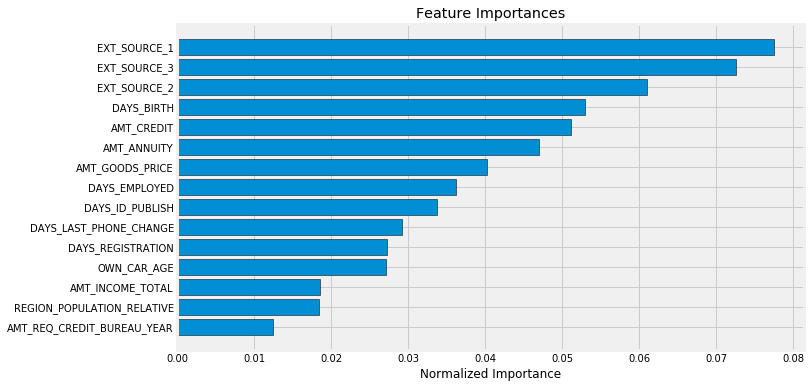

In [73]:
fi_sorted = plot_feature_importances(fi)

In [74]:
submission.to_csv('control.csv', index = False)

在比赛中，该控制器的分数为0.745

### 测试一
让我们进行第一次测试。我们只需要把数据传递给函数，函数就完成了我们的大部分工作。

In [75]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766471	train's auc: 0.810385
Early stopping, best iteration is:
[293]	valid's auc: 0.767203	train's auc: 0.827287
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767523	train's auc: 0.810288
Early stopping, best iteration is:
[265]	valid's auc: 0.768109	train's auc: 0.822264
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.761029	train's auc: 0.811653
Early stopping, best iteration is:
[267]	valid's auc: 0.761625	train's auc: 0.824147
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767837	train's auc: 0.809671
Early stopping, best iteration is:
[236]	valid's auc: 0.76815	train's auc: 0.816322
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767516	train's auc: 0.809788
[400]	valid's auc: 0.76758

In [76]:
metrics_raw

,fold,train,valid
0,0,0.827287,0.767203
1,1,0.822264,0.768109
2,2,0.824147,0.761625
3,3,0.816322,0.768150
4,4,0.828518,0.767902
5,overall,0.823708,0.766597


从数字上看，处理后的特征训练的效果优于原始特征，但是只有把预测数据提交之后，才可以确定这种更好的验证性能是否转移到了测试数据中

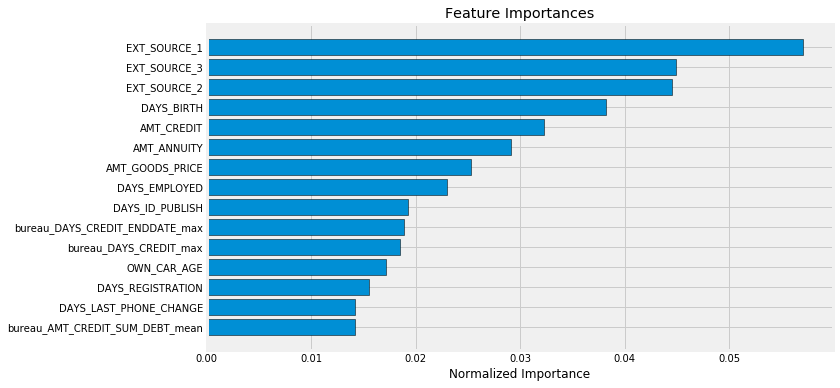

In [77]:
fi_raw_sorted = plot_feature_importances(fi_raw)

通过检查特征的重要性发现，我们构造的一些特征是似乎是最重要的。我们可以找出本文所做的最重要的100个特征的百分比。但是，我们不仅仅要与原始的特征进行比较，还需要与hot-encode后的原始特征进行比较。这些已经记录在我们的FI（原始数据）中

In [79]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 53.00


超过一半的重要特征都是由我们创造的！这让我们相信，我们所做的一切努力都是值得的

In [80]:
submission_raw.to_csv('test_one.csv', index = False)

在比赛中，测试一的分数为0.759

### 测试二
这很容易，所以让我们继续吧！同以前一样，但将高度共线的变量删除

In [81]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764122	train's auc: 0.8063
Early stopping, best iteration is:
[264]	valid's auc: 0.764565	train's auc: 0.817897
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.7652	train's auc: 0.806611
[400]	valid's auc: 0.765625	train's auc: 0.839251
Early stopping, best iteration is:
[379]	valid's auc: 0.765829	train's auc: 0.836334
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757092	train's auc: 0.808063
Early stopping, best iteration is:
[198]	valid's auc: 0.757149	train's auc: 0.807627
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764131	train's auc: 0.806097
Early stopping, best iteration is:
[287]	valid's auc: 0.76481	train's auc: 0.821551
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763964	tr

In [82]:
metrics_corr

,fold,train,valid
0,0,0.817897,0.764565
1,1,0.836334,0.765829
2,2,0.807627,0.757149
3,3,0.821551,0.764810
4,4,0.825298,0.764449
5,overall,0.821741,0.763352


这些结果优于之前的控制器，但是略低于原始特征

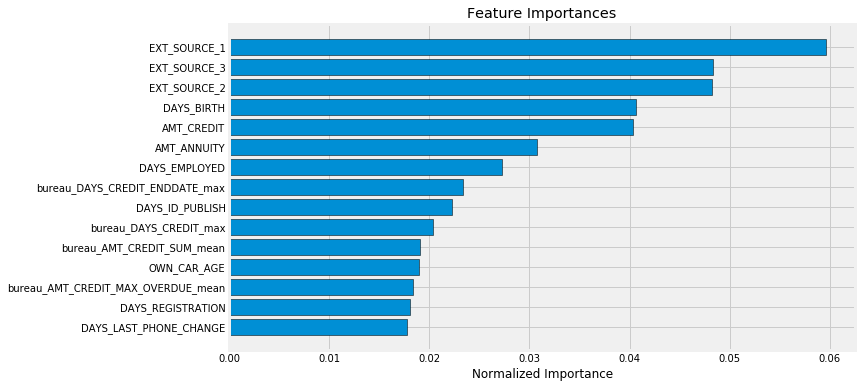

In [83]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [84]:
submission_corrs.to_csv('test_two.csv', index = False)

在比赛中，测试二的分数为0.753

## 结果
在完成了所有的工作之后，我们可以说，额外添加的信息确实提高了性能！该模型显然没有优化我们的数据，但相比于原来的数据集，仍然有明显的改善。让我们正式总结一下表现：

Experiment	Train AUC	Validation AUC	Test AUC
Control	0.815	0.760	0.745
Test One	0.837	0.767	0.759
Test Two	0.826	0.765	0.753

我们所有的辛勤工作转化为了一个小改进——0.014。去除高度共线性的变量会稍微降低性能，所以我们要考虑不同的特征选择方法。此外，我们可以说，我们所构建的很多特征包含于模型所判断的最重要的100个特征中

在这样的比赛中，即使是这种程度的微小提高也足以让我们上升100多位。通过在本文中进行许多小的改进，我们可以逐步实现更好的性能。我鼓励其他人利用这里的结果来改进自己的代码，我将继续记录我帮助他人的步骤

## 下一步
下一步，我们会将本文中开发的代码应用到其他数据集上。在我们的模型中还有4个其他的数据文件！在下一章中，我们将把这些其他数据文件（其中包含有关以前在家庭信贷贷款的信息）中的信息合并到我们的训练数据中。然后，我们可以建立相同的模型，并运行更多的实验来确定我们的特征工程的效果。在这场比赛中还有很多工作要做，还有更多的成绩要做！我们会在下一章中再见